In [59]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import tensorflow.keras as kb
from tensorflow.keras import backend
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU


from plotnine import *

from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

In [43]:
url = 'https://raw.githubusercontent.com/min-is/nba/refs/heads/main/datasets/jaysontatum24_25.csv'
df = pd.read_csv(url)
df = pd.get_dummies(df, columns = ["Opp"])

df = df.fillna(0)  # Replace NaNs
df = df.replace([np.inf, -np.inf], 0)

features = [col for col in df.columns if col != "PTS"]

df.head()
print(features)

['Ven', 'WinMar', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'GmSc', 'Rtg', 'TS%', 'eFG%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg', 'BPM', 'Opp_ATL', 'Opp_BRK', 'Opp_CHI', 'Opp_CHO', 'Opp_CLE', 'Opp_DAL', 'Opp_DEN', 'Opp_DET', 'Opp_GSW', 'Opp_HOU', 'Opp_IND', 'Opp_LAC', 'Opp_LAL', 'Opp_MEM', 'Opp_MIA', 'Opp_MIL', 'Opp_MIN', 'Opp_NOP', 'Opp_NYK', 'Opp_OKC', 'Opp_ORL', 'Opp_PHI', 'Opp_PHO', 'Opp_POR', 'Opp_SAC', 'Opp_SAS', 'Opp_TOR', 'Opp_UTA', 'Opp_WAS']


In [82]:

X = df[features]
y = df["PTS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

z = StandardScaler()
X_train_scaled = z.fit_transform(X_train)
X_test_scaled = z.transform(X_test)

model = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],)),
    LeakyReLU(alpha=0.01),  # Use Leaky ReLU for more stable training
    Dense(256),
    LeakyReLU(alpha=0.01),
    Dense(128),
    Dense(128),
    LeakyReLU(alpha=0.01),
    Dense(64),
    LeakyReLU(alpha=0.01),
    Dense(64),
    Dropout(0.2),
    Dense(32),
    Dense(16),
    LeakyReLU(alpha=0.01),
    Dense(8),
    Dense(4),
    Dense(1)  # No activation for regression task
])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 256)               16896     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_118 (Dense)           (None, 256)               65792     
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_119 (Dense)           (None, 128)               32896     
                                                                 
 dense_120 (Dense)           (None, 128)               16512     
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 128)             

In [83]:
optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='mse', metrics=["mae"])


# Train Model
history = model.fit(
    X_train_scaled, y_train,
    epochs=2000, batch_size=32,
    validation_data=(X_test_scaled, y_test),
    verbose=1
)

Epoch 1/2000
4/4 [==============================] - 1s 33ms/step - loss: 761.2051 - mae: 26.6085 - val_loss: 852.9413 - val_mae: 28.4416
Epoch 2/2000
4/4 [==============================] - 0s 7ms/step - loss: 760.7414 - mae: 26.6044 - val_loss: 852.1638 - val_mae: 28.4282
Epoch 3/2000
4/4 [==============================] - 0s 8ms/step - loss: 760.3755 - mae: 26.5933 - val_loss: 851.4198 - val_mae: 28.4155
Epoch 4/2000
4/4 [==============================] - 0s 7ms/step - loss: 759.5944 - mae: 26.5833 - val_loss: 850.6881 - val_mae: 28.4029
Epoch 5/2000
4/4 [==============================] - 0s 8ms/step - loss: 758.9827 - mae: 26.5746 - val_loss: 849.9485 - val_mae: 28.3902
Epoch 6/2000
4/4 [==============================] - 0s 7ms/step - loss: 758.5947 - mae: 26.5588 - val_loss: 849.2281 - val_mae: 28.3778
Epoch 7/2000
4/4 [==============================] - 0s 7ms/step - loss: 757.1527 - mae: 26.5332 - val_loss: 848.5087 - val_mae: 28.3654
Epoch 8/2000
4/4 [=============================

In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicting the target (PTS) on the test set
y_pred = model.predict(X_test_scaled)

# Calculating performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

1/1 [==============================] - 0s 52ms/step
Mean Absolute Error (MAE): 3.0236553045419545
Mean Squared Error (MSE): 15.093492290925356
Root Mean Squared Error (RMSE): 3.885034400224193
R-squared (R²): 0.6533767907098267


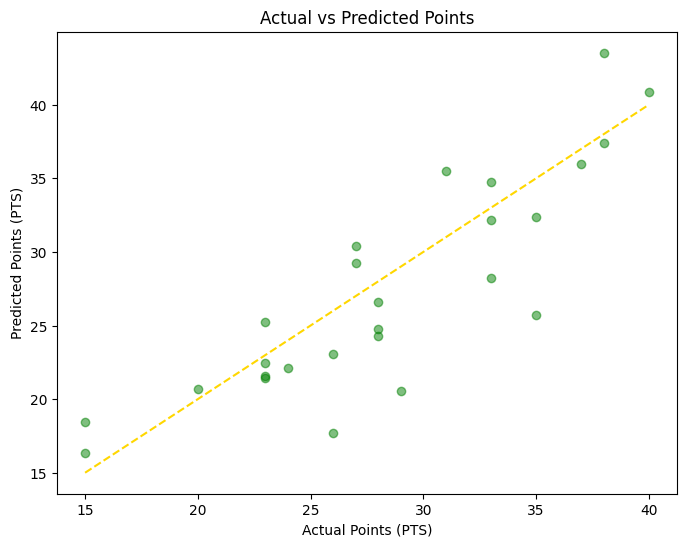

In [88]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='gold', linestyle='--')
plt.xlabel("Actual Points (PTS)")
plt.ylabel("Predicted Points (PTS)")
plt.title("Actual vs Predicted Points")
plt.show()

In [119]:
def get_average_stats_against_opponent(df, opponent):
    opponent_column = f"Opp_{opponent}"  # Generate the column name for the opponent
    if opponent_column not in df.columns:
        raise ValueError(f"Opponent column {opponent_column} does not exist in the dataset.")
    
    opponent_data = df[df[opponent_column] == 1]  # Only games against the specified opponent
    average_stats = opponent_data[features].mean()  # Calculate the average of the relevant features
    
    return average_stats

opponent = "MIN"
average_stats_cavs = get_average_stats_against_opponent(df, opponent)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])


input_data = average_stats_cavs.values.reshape(1, -1)  # Reshape for single prediction

input_data_scaled = scaler.transform(input_data)

predicted_points = model.predict(input_data_scaled)

print(f"Predicted points for Jayson Tatum against {opponent}: {predicted_points[0]}")


1/1 [==============================] - 0s 12ms/step
Predicted points for Jayson Tatum against MIN: [29.101252]
